# Cell Community Detection (CCD) tutorial

Sequencing technology advances applied in spatial transcriptomics opened a new window into the tissue microenvironment. By capturing gene expression profiles of individual cells along with their spatial coordinates, researchers have gained the ability to accurately ascertain cell types and their respective functions. While some cell types are known to coexist within various regions of the tissue, the co-occurrence of many others remains elusive.

The proposed __Cell Community Detection (CCD) algorithm__ addresses this challenge by offering a novel computational approach for identifying tissue domains with a significant mixture of particular cell types. The CCD algorithm divides the tissue using _sliding windows_, quantifies the proportion of each cell type within each window, and groups together windows with similar cell type mixtures. By employing _majority voting_, the algorithm assigns a community label to each cell based on the labels of windows covering it. Notably, CCD accommodates multiple window sizes and enables the simultaneous analysis of multiple slices from the same tissue. Its Python implementation with a flexible user interface enables the processing of datasets with tens of thousands of cells in sub-minute execution time.

### CCD as part of Stereopy

CCD is a part of the algorithm module of Stereopy. It expects an Anndata or a list of Anndata objects as input, depending on single or multiple slice processing. CCD can process samples from all types of spatial transcriptomics technologies.

In [ ]:
from stereo.core.stereo_exp_data import AnnBasedStereoExpData
from stereo.algorithm.community_detection import CommunityDetection

Download a sample slice, Stereo-seq Mouse Embryo Whole brain.

In [ ]:
# Fetch data
!wget URL = 'https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/stomics/E16.5_E1S3_cell_bin_whole_brain.h5ad'

### Data preparation

In order to be processed by CCD, an Anndata object (each of them) requires:
-  cell spatial coordinates,
-  cell type annotation and
-  cell type color palette.

Spatial coordinates should be placed in <font color=green>.obsm['spatial']</font>, cell annotation labels in <font color=green>.obs['<annotation_name>']</font> and color palette for cell types in <font color=green>.uns['<annotation_name>_colors']</font>.

In [4]:
adata = AnnBasedStereoExpData('E16.5_E1S3_cell_bin_whole_brain.h5ad')
adata

AnnData object with n_obs × n_vars = 65303 × 23368
    obs: 'Slice', 'region', 'sim anno', 'n_genes_by_counts', 'total_counts', 'annotation'
    var: 'Gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sim anno_colors', 'sn'
    obsm: 'spatial'
    layers: 'counts'

### Run CCD

CCD is run using the main class CommunityDetection. Creation of an object of this class requires only list of slices (Anndata objects) and annotation label (<font color=green><annotation_name></font>). All other available parameters and their default values can be found in /stereo/algorithm/ccd/constants.py

In the current example CCD is run for single slice of mouse embryo whole brain Stereo-seq sample. Window size is set to 150, and sliding step to 50. This provides, on average, 30 cells per window. By employing scatteredness threshold and downsampling rate cell types that are spread throughout the tissue, providing no localization or community perspective, are removed. Hierarchical agglomerative clustering algorithm with ward linkage is chosen with predefined number of 16 clusters.

In [ ]:
cd = CommunityDetection(slices=[adata], annotation='sim anno', win_sizes='150', sliding_steps='50', scatter_thres=0.12, cluster_algo='agglomerative', n_clusters=16)
cd.main()

CCD suports a wide range of visualizations, created in order to provide the user with deep insight into the data. Visualizations cover basic annotation and CCD cluster plots, as well as tables containing cell mixtures data and cell type abundances per cluster and type. Additionally, per community plots are supported for analysis and comparison in case/control scenarios. 

Cell type annotation:

Function plot_spatial took 0.1918s


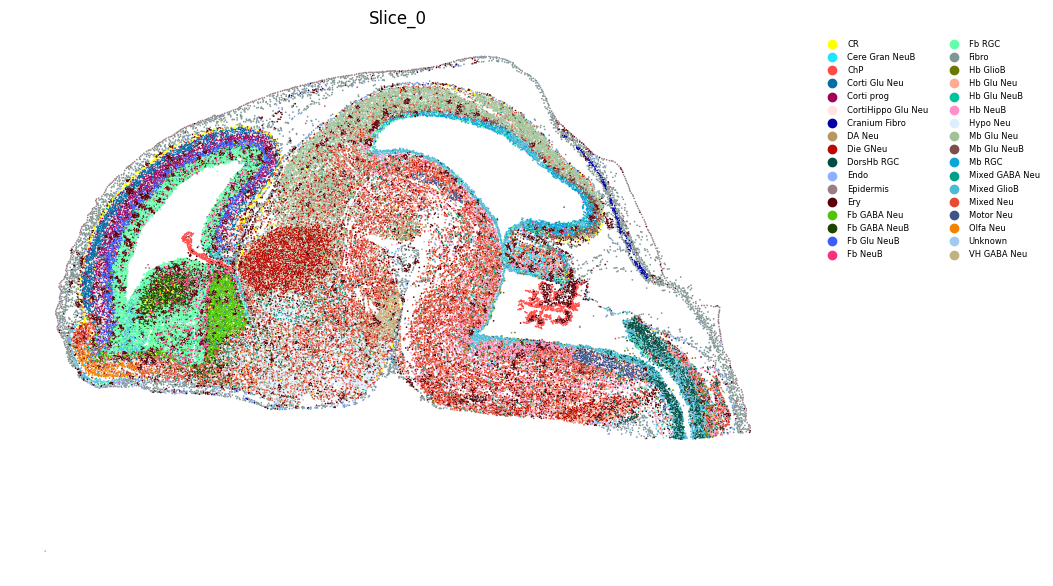

Function plot_annotation took 1.2618s


In [6]:
# Show cell types distribution
cd.plot("annotation")

Cell Community Detection result - community clusters:

Function plot_spatial took 0.1842s


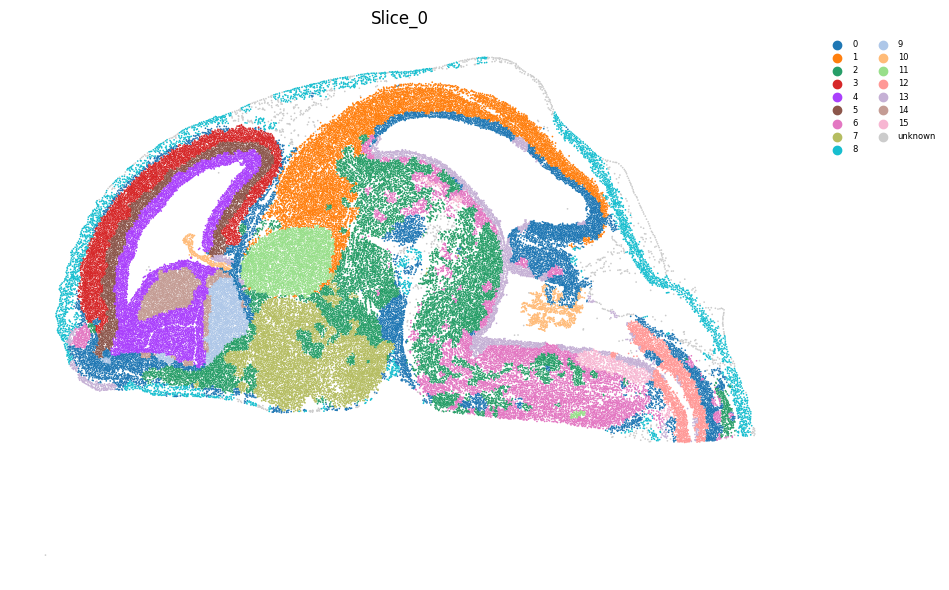

Function plot_clustering took 0.9544s


In [8]:
# Plot comunities (functional modules)
cd.plot("clustering")

Bar plot of cell communities abundance in tissue slice

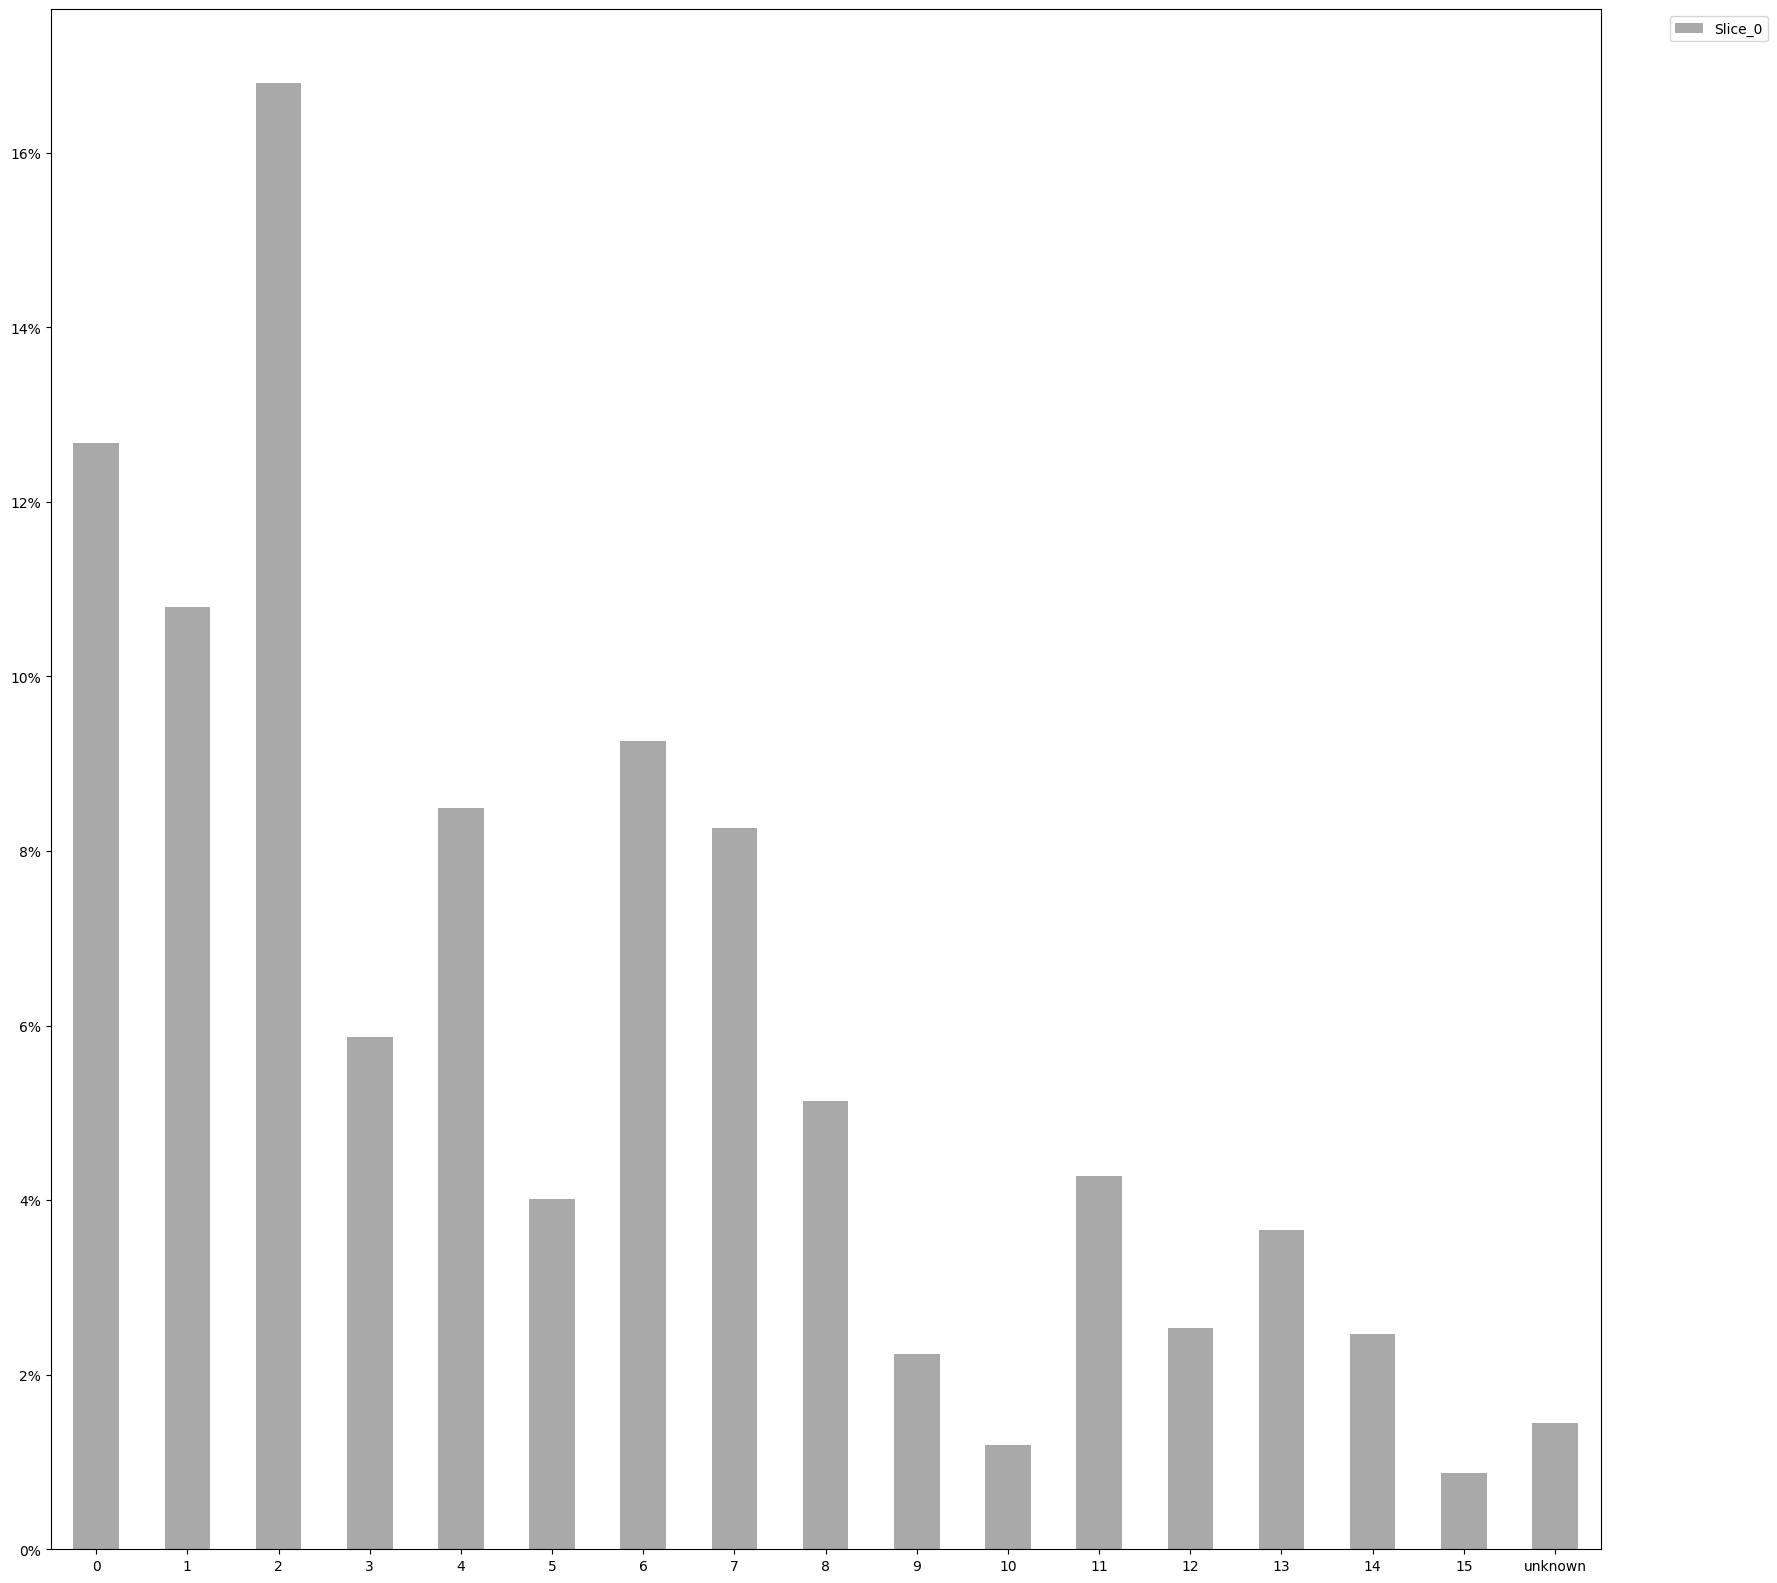

Function plot_cluster_abundance_total took 0.3171s


In [9]:
# Show percentages of presence of communities detected in the slice
cd.plot("cluster_abundance_total")

Table of cell type abundances per cluster and type (colors are matche with cluster and cell type annotation colors).

This table allows user to detect the infuence of cell types on different communities, especially when cell types have small number of cells in the slice.

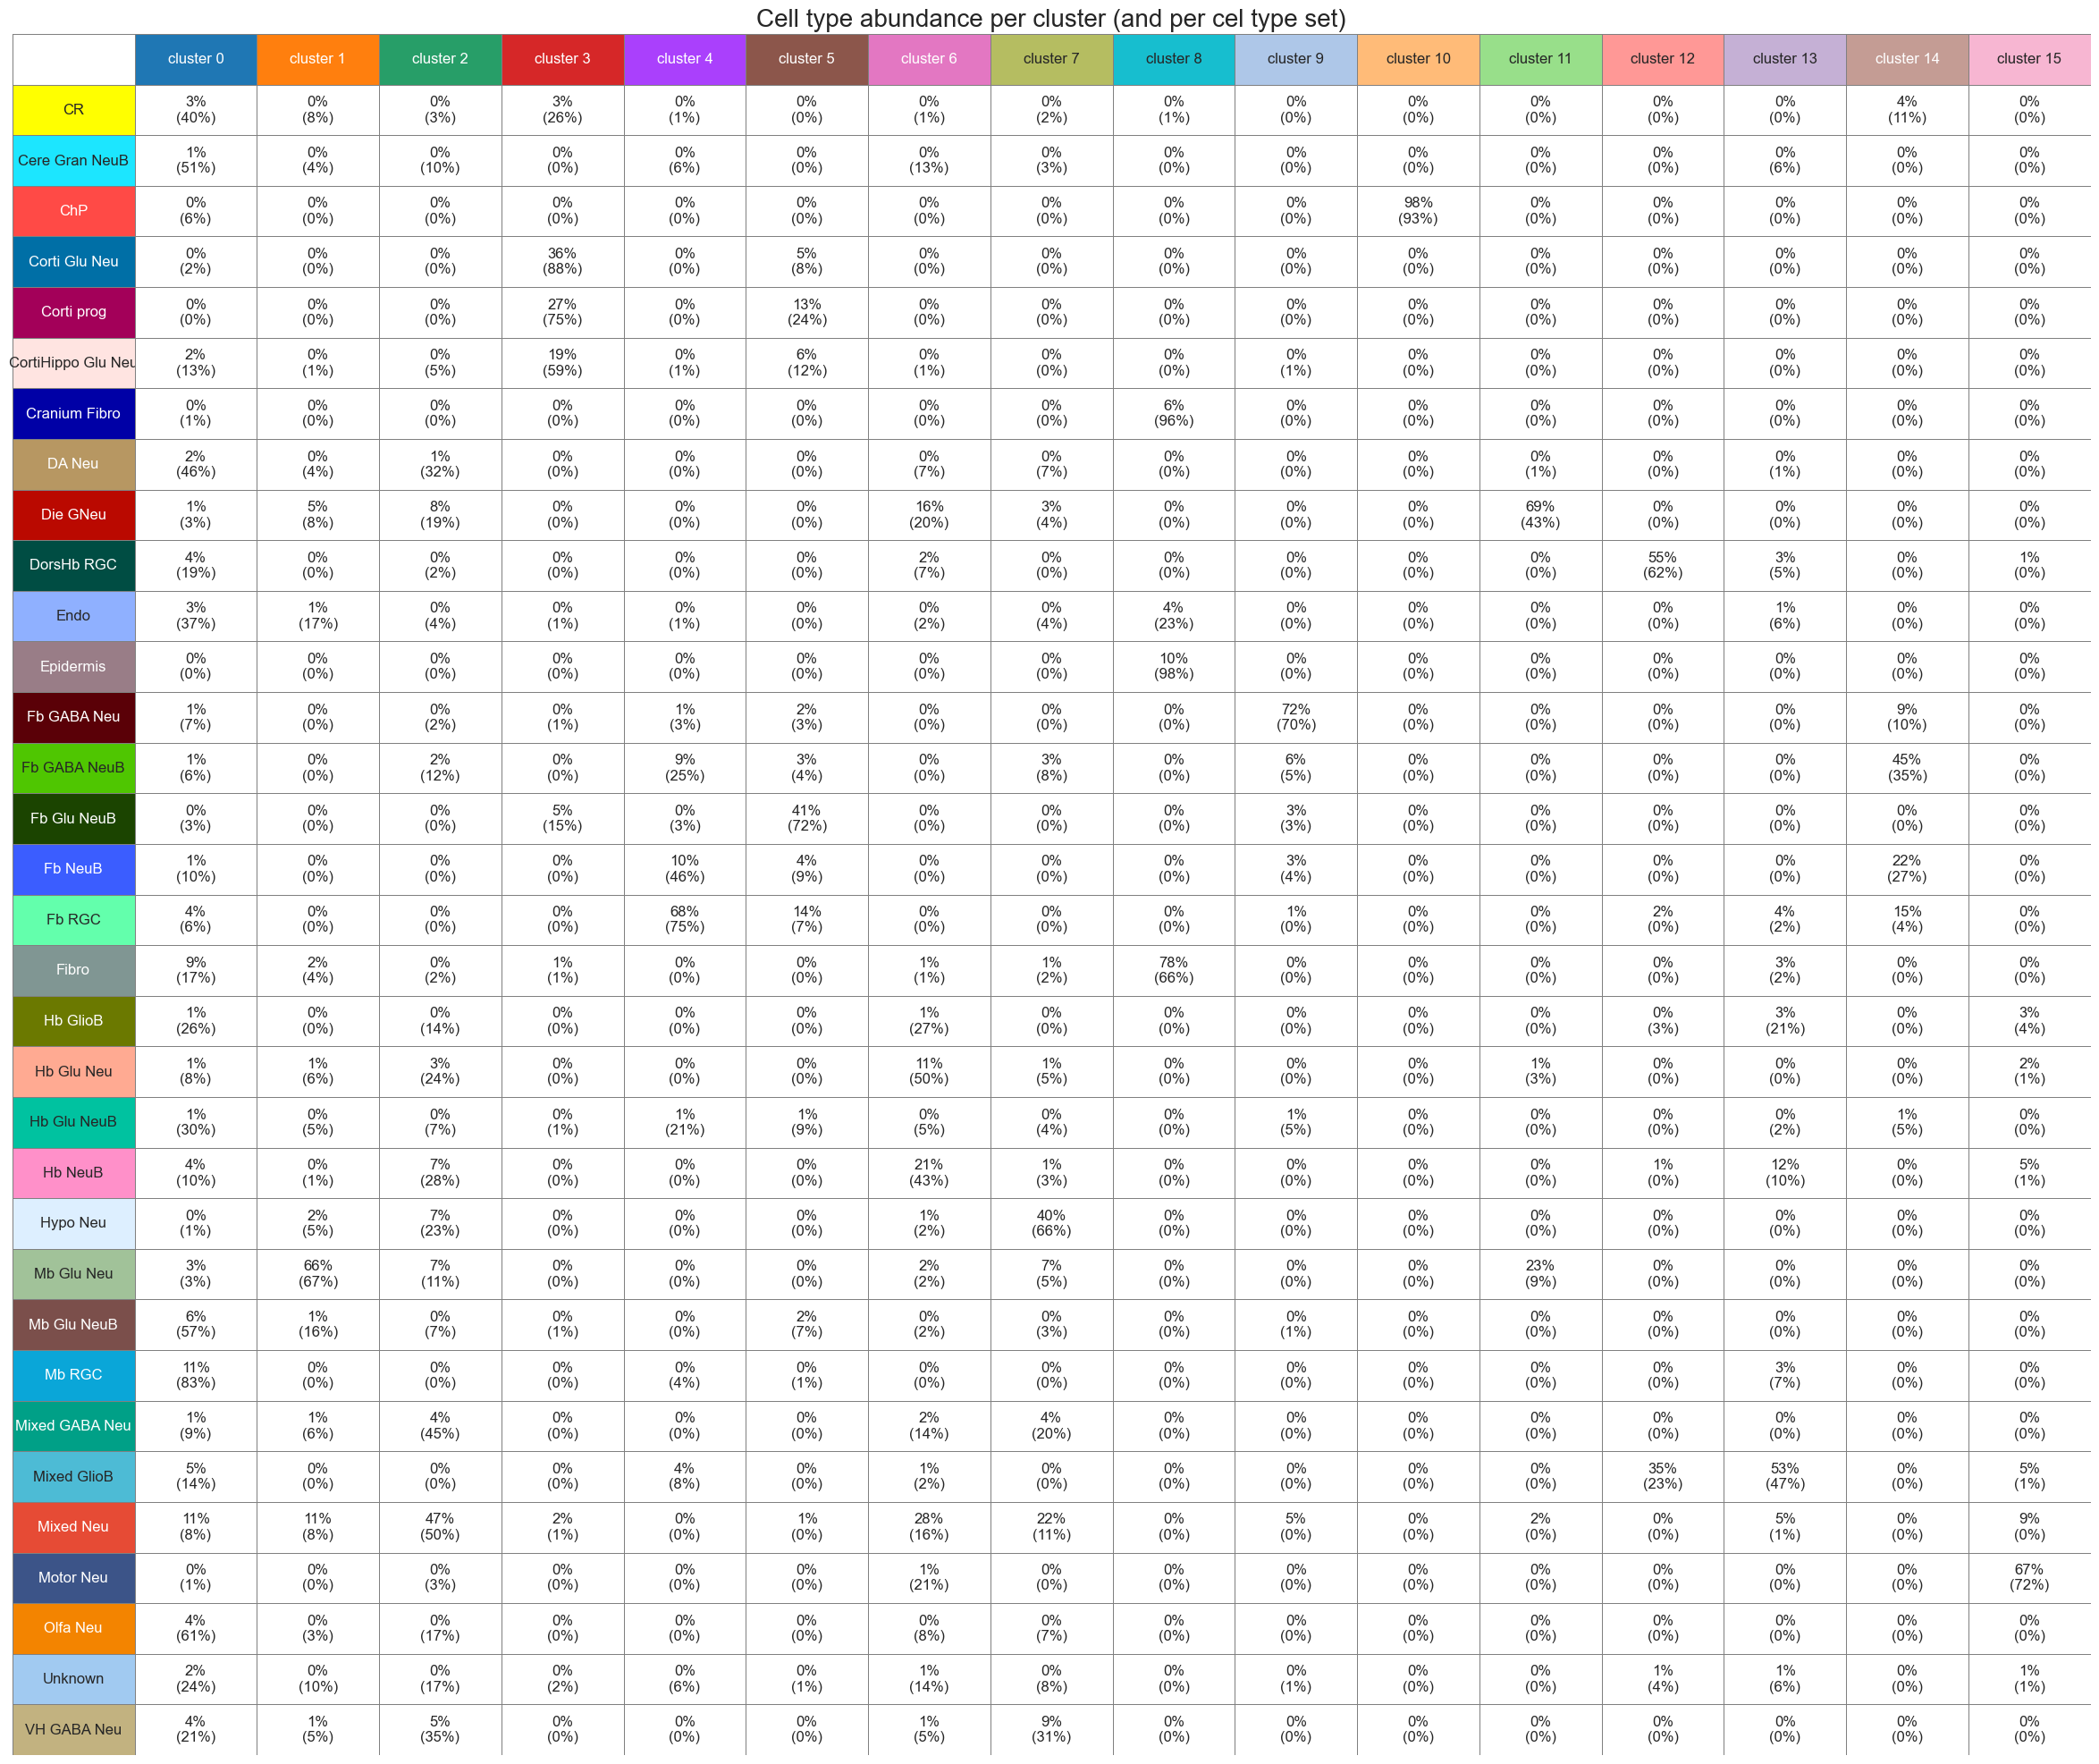

Function plot_celltype_table took 6.7963s


In [10]:
# Plot percentages of cell types across communities
cd.plot("cell_types_table")

#### Per community plots

Display of cell type mixtures for specified community. Provides insight on spatial influence and cell type abundance.

Function plot_spatial took 0.1984s
Function plot_spatial took 0.1631s


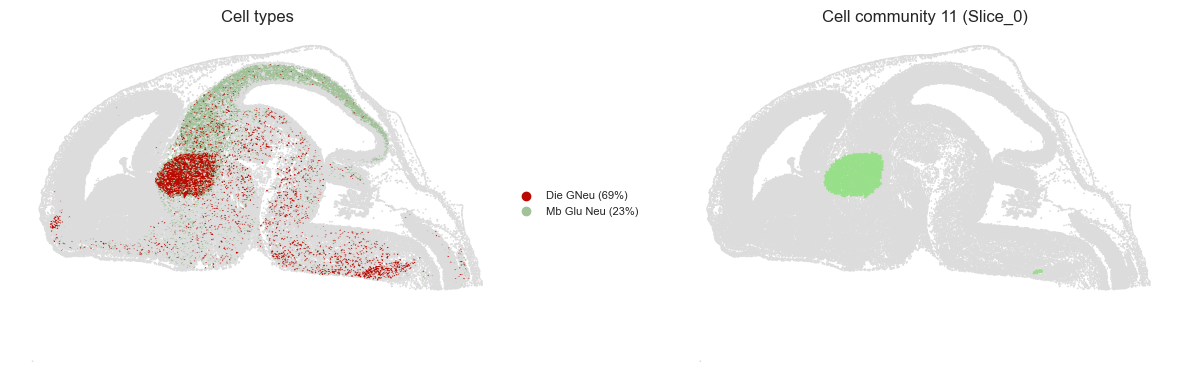

Function plot_cluster_mixtures took 1.5229s
Function plot_spatial took 0.2252s
Function plot_spatial took 0.1639s


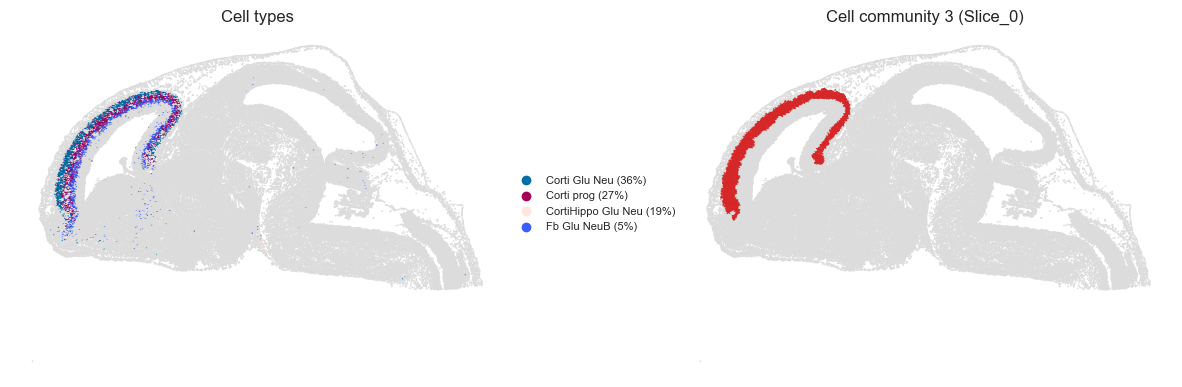

Function plot_cluster_mixtures took 1.5394s


In [11]:
# Plot cell types in community 11 and 3
cd.plot("cluster_mixtures", community_id=11)
cd.plot("cluster_mixtures", community_id=3)

Boxplot of cell type percentages in a community per each window that belongs to the community.

This plot provides information on community uniformity and smoothness. Significant variance in cell type percentages suggest possible merge of several communities and need for increase of the clustering resolution (as shown for community 3).

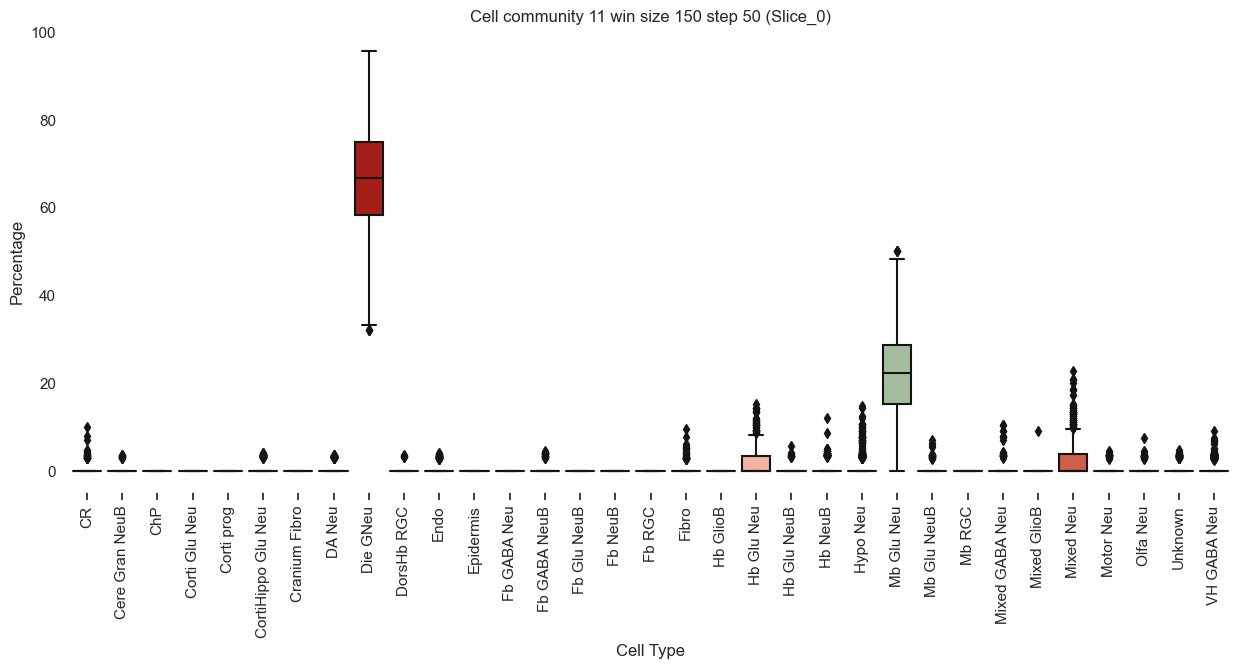

Function boxplot_stats took 0.5365s


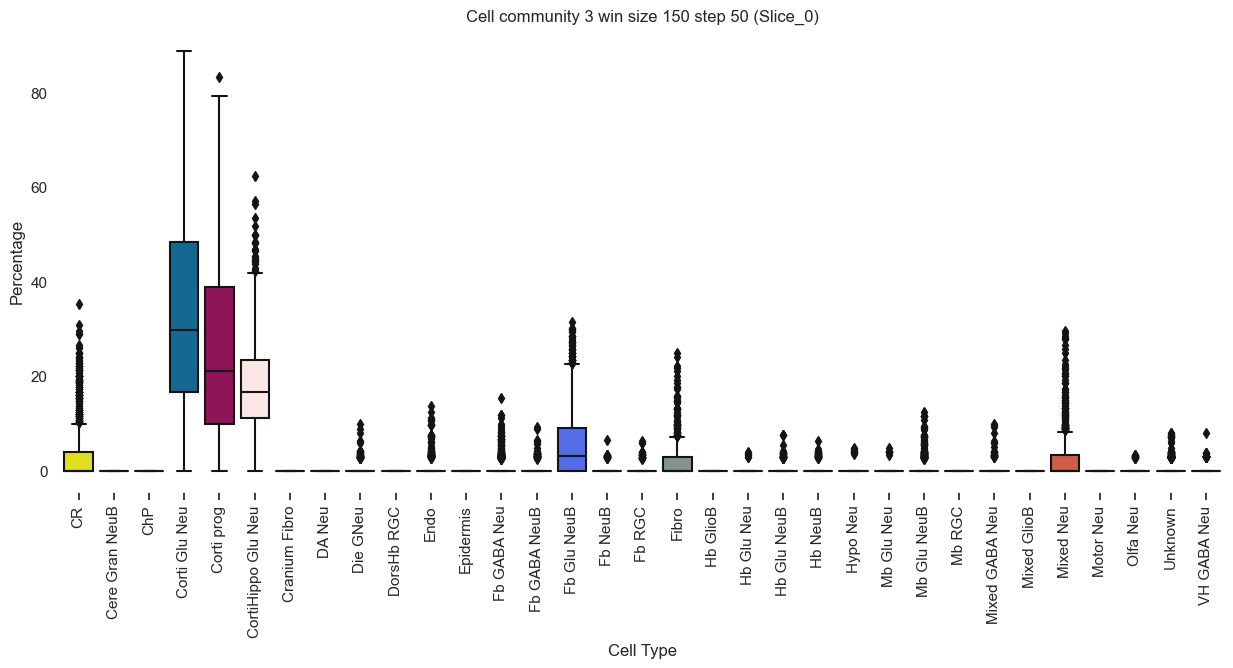

Function boxplot_stats took 0.5007s


In [12]:
# Plot percentage of presence of cell types in windows belonging to community 11 and 3
cd.plot("boxplot", community_id=11)
cd.plot("boxplot", community_id=3)

Colorplot of cell percentages in a community per each window that belongs to the community. The percentages of top three cell types in the community for each window are used as R,G and B values and plotted over the tissue image.

This plot provides visual spatial information on community uniformity and smoothness. Significant difference in cell type percentages provides different colors and shows the possible existence of several communities and need for increase of the clustering resolution (as shown for community 3).

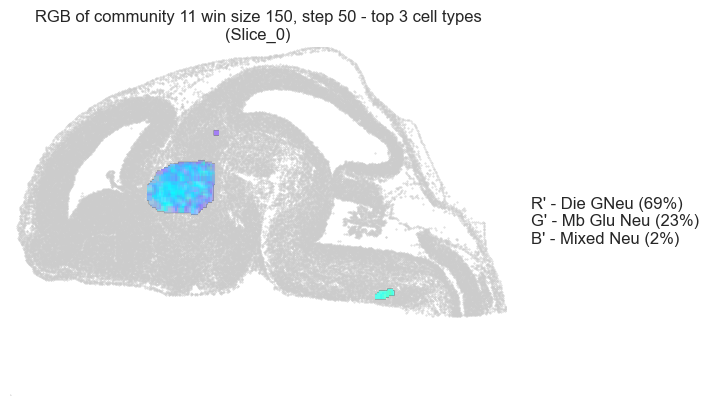

Function colorplot_stats took 36.2665s


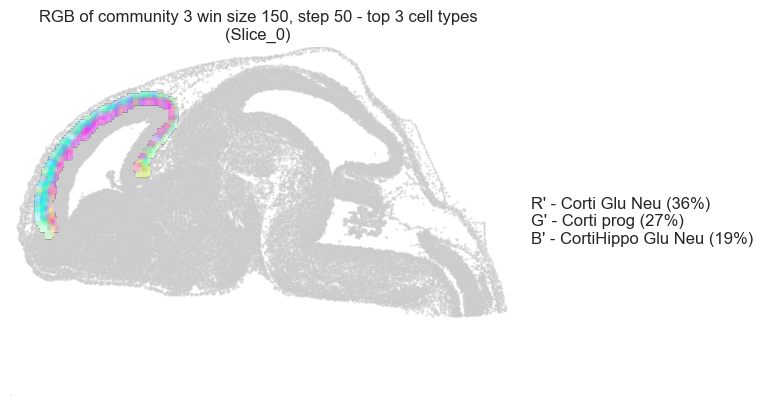

Function colorplot_stats took 28.9329s


In [13]:
# Plot for community 11 and 3 of windows colored using percentages of top 3 cell types mapped into R, G and B color channels
cd.plot("colorplot", community_id=11)
cd.plot("colorplot", community_id=3)

### Multi-size sliding window approach

CCD divides the tissue using sliding windows by accommodating multiple window sizes, and enables the simultaneous analysis of multiple slices from the same tissue. CCD consists of the three main steps:

1. Single or multiple-size sliding windows ($w$) are moved through the surface of the tissue with defined horizontal and vertical step while calculating the percentages ($[p_1, p_2,...,p_n]$) of each cell type inside of it. A feature vector ($fv$) with size equal to the number of cell types ($n$) is created for each processed window across all available tissue slices: 
 
  \begin{equation}
    \forall w_i\rightarrow (fv_i = [p_1, p_2,...,p_n])
  \end{equation}

2. Feature vectors from all windows are fed to the clustering algorithm ($C$) such as Leiden, Spectral or Hierarchical to obtain community labels ($l$). The number of the desired communities ($cn$) can be predefined explicitly as a parameter (Spectral or Hierarchical clustering) or by setting the resolution of clustering (Leiden):
  
  \begin{equation}
    C(\forall fv_i) \rightarrow l_i, l_i \in {l_1, l_2, ..., l_{cn}}
  \end{equation}
  
3. Community label is assigned to each cell-spot ($cs$) by majority voting ($MV$) using community labels from all windows covering it:

  \begin{equation}
        MV(\forall l_i)\text{ where } spatial(cs_j) \in w_i \rightarrow l_j, l_j \in {l_1, l_2, ..., l_{cn}}
  \end{equation}

The window size and sliding step are optional CCD parameters. If not provided, the optimal window size is calculated throughout the iterative process with goal of having average number of cell-spots in all windows in range [30, 50]. Sliding step is set to the half of the window size.

### Additional options

CCD also includes several filtering steps controlled with parameters, such as removal of cell types present in all parts of the tissue and removal of windows with too small number of cell-spots: 
- Spatial distribution of each cell type can be evaluated using 2D entropy and scatteredness metrics. CCD supports setting the threshold values for these metrics in order to exclude cell types which are randomly or evenly spread throughout the tissue from processing. Removing cell types with high entropy and scatteredness improves clustering and provides more robust cell communities.
- The robustness and quality of CCD strongly depends on clustering. In order for clustering to be stable, feature vectors need to contain significant amount of information, that is, enough cell-spots in each evaluated window. CCD gathers data on total cell numbers per window and supports setting a threshold value for minimum cell-spot number for the window to be included in the clustering process. Cell-spots are marked with <font color='grey'>_'unknown'_</font> label if there are no cell community labeled windows that overlap them.

Final results and visualisations produced by CCD are aggregated into the structured HTML report enabling researches to get the full insight into the obtained communities and their statistics.